In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import pandas as pd
%matplotlib inline


In [2]:
data = pd.read_excel("bankloan.xls")

In [3]:
def get_set(data,i):

    N,L = data.shape
    data = data.sample(frac=1).reset_index(drop=True)
    x_train = data.iloc[:int(N*i),:-1].values.reshape(-1,8)
    y_train = data.iloc[:int(N*i),-1].values.reshape(-1,1)
    x_test = data.iloc[int(N*i):,:-1].values.reshape(-1,8)
    y_test = data.iloc[int(N*i):,-1].values.reshape(-1,1)
    return torch.from_numpy(x_train).float(),torch.from_numpy(x_test).float(),torch.from_numpy(y_train).float(),torch.from_numpy(y_test).float()


In [4]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.lr = nn.Linear(8, 1)
        self.sm = nn.Sigmoid()
    def forward(self, x):
        out = self.lr(x)
        #print(x)
        out = self.sm(out)
        return out

In [5]:

def lr_model_build(x_train,y_train,thres = 0.5,epoches = 10000):
    if torch.cuda.is_available():
        logistic_model = LogisticRegression().cuda()
    else:
        logistic_model = LogisticRegression()
    criterion = nn.BCELoss()      
    optimizer = optim.SGD(logistic_model.parameters(), lr=1e-3, momentum=0.9)

    acc_end =0 
    precision = 0
    recall = 0
    for epoch in range(epoches):

        if torch.cuda.is_available():
            x_train = Variable(x_train).cuda()
            y_train = Variable(y_train).cuda()
        else:
            x_train = Variable(x_train)
            y_train = Variable(y_train)

        out = logistic_model(x_train)
        loss = criterion(out, y_train)

        mask = out.ge(thres).float()
        correct = (mask == y_train).sum().float()
        acc = correct/x_train.size(0)
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #print(loss.data)
        # if (epoch+1) % 1000 == 0:
        #     print('*'*10)
        #     print("eopch {}, loss is {:.4f}, acc is {:.4f}".format(epoch+1, loss, acc))
        acc_end = acc
        precision = (((mask == y_train)&(mask ==1)).sum().float())/(y_train == 1).sum().float()
        recall = (((mask == y_train)&(mask ==0)).sum().float())/(y_train == 0).sum().float()
        fpr = (((mask != y_train)&(mask ==1)).sum().float())/(y_train == 0).sum().float()
        torch.save(logistic_model,'model.pkl')
    return acc_end,precision,recall,fpr



In [6]:
def pre_test(test_x,test_y,thres = 0.5):
    y_pred = logistic_model(test_x)
    mask = y_pred.ge(thres).float()
    correct = (mask == test_y).sum().float()
    acc = correct/test_x.size(0)
    precision = (((mask == test_y)&(mask ==1)).sum().float())/(test_y == 1).sum().float()
    recall = ((mask == test_y)&(mask ==0)).sum().float()/(test_y == 0).sum().float()
    fpr = (((mask != test_y)&(mask ==1)).sum().float())/(test_y == 0).sum().float()
    # print("test set")
    # print("correct:",correct)
    # print("accuracy:",acc)
    return acc,precision,recall,fpr

# problem 1

In [7]:
train_rate = [0.05,0.15,0.50,0.75,0.85]
avg_tr = [0]*5
std_tr = [0]*5
avg_te = [0]*5
std_te = [0]*5
e = 0
for r in train_rate:
    acc_train = [0]*100
    acc_test = [0]*100
    for i in range(100):
        x_train,x_test,y_train,y_test = get_set(data,r)
        acc_train[i],_,_,_ = lr_model_build(x_train,y_train,epoches = 1000)
        logistic_model = torch.load("model.pkl")
        acc_test[i],_,_,_  = pre_test(x_test,y_test)
    print("#"*10)
    print("When the train set is {} of total data".format(r))
    print("average of train accuracy:{:.4f}".format(np.average(acc_train)))
    print("average of test accuracy:{:.4f}".format(np.average(acc_test)))
    print("std of train accuracy:{:.4f}".format(np.std(acc_train)))
    print("std of test accuracy:{:.4f}".format(np.std(acc_test)))
    
    avg_tr[e] = np.average(acc_train)
    avg_te[e] = np.average(acc_test)
    std_tr[e] = np.std(acc_train)
    std_te[e] = np.std(acc_test)
    e = e+1



##########
When the train set is 0.05 of total data
average of train accuracy:0.8660
average of test accuracy:0.7515
std of train accuracy:0.0804
std of test accuracy:0.0567
##########
When the train set is 0.15 of total data
average of train accuracy:0.8341
average of test accuracy:0.7895
std of train accuracy:0.0318
std of test accuracy:0.0137
##########
When the train set is 0.5 of total data
average of train accuracy:0.8185
average of test accuracy:0.8037
std of train accuracy:0.0155
std of test accuracy:0.0152
##########
When the train set is 0.75 of total data
average of train accuracy:0.8145
average of test accuracy:0.8106
std of train accuracy:0.0100
std of test accuracy:0.0273
##########
When the train set is 0.85 of total data
average of train accuracy:0.8152
average of test accuracy:0.8066
std of train accuracy:0.0074
std of test accuracy:0.0314


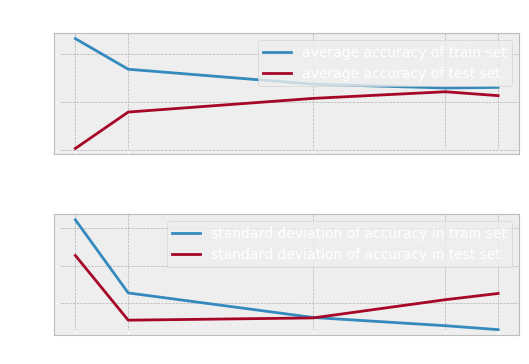

In [12]:
plt.rcParams['savefig.dpi'] = 100 #图片像素
plt.rcParams['figure.dpi'] = 100 #分辨率
plt.figure(1)
plt.subplots_adjust(wspace =0, hspace =0.5)#调整子图间距
plt.subplot(211)
plt.style.use("bmh")
plt.xticks(train_rate)
plt.title("average accuracy")
plt.plot(train_rate,avg_tr,label = "average accuracy of train set")
plt.plot(train_rate,avg_te,label = "average accuracy of test set")
plt.legend(loc='upper right')
plt.subplot(212)
plt.style.use("bmh")
plt.title("standard deviation of accuracy")
plt.xticks(train_rate)
plt.plot(train_rate,std_tr,label = "standard deviation of accuracy in train set")
plt.plot(train_rate,std_te,label = "standard deviation of accuracy in test set")
plt.legend(loc='upper right')

### According to the figure,we can see that as the training set becomes larger and testing set becomes smaller,the average accuracy of train set is getting lower and the test set is getting higher.The standard deviation of accuracy has the same trend.That's because when the train set is too small,the model is underfitting and when it's too large,the model is overfitting.

# problem 2

In [9]:
x_train,x_test,y_train,y_test = get_set(data,0.7)

In [10]:
h = np.linspace(0,1,30) 

In [11]:
tpr = []
fpr = []
for thres in h:
    acc,precision,recall,_ = lr_model_build(x_train,y_train,thres)
    logistic_model = torch.load("model.pkl")
    acc_t,precision_t,recall_t,fpr_t = pre_test(x_test,y_test,thres)
    print("#"*10)
    print("When the threshold is {:.4f}".format(thres))
    print("The train set:")
    print("precision:{:.4f},recall:{:.4f}".format(precision,recall))
    print("The test set:")
    print("pricision:{:.4f},recall:{:.4f}".format(precision_t,recall_t))
    tpr.append(precision_t)
    fpr.append(fpr_t)



##########
When the threshold is 0.0000
The train set:
precision:1.0000,recall:0.0000
The test set:
pricision:1.0000,recall:0.0000
##########
When the threshold is 0.0345
The train set:
precision:0.9921,recall:0.2534
The test set:
pricision:1.0000,recall:0.2532
##########
When the threshold is 0.0690
The train set:
precision:0.9603,recall:0.3554
The test set:
pricision:0.9825,recall:0.3506
##########
When the threshold is 0.1034
The train set:
precision:0.9365,recall:0.4408
The test set:
pricision:0.9649,recall:0.4416
##########
When the threshold is 0.1379
The train set:
precision:0.9127,recall:0.5124
The test set:
pricision:0.9649,recall:0.5195
##########
When the threshold is 0.1724
The train set:
precision:0.8968,recall:0.5923
The test set:
pricision:0.9649,recall:0.6299
##########
When the threshold is 0.2069
The train set:
precision:0.8730,recall:0.6419
The test set:
pricision:0.9474,recall:0.6818
##########
When the threshold is 0.2414
The train set:
precision:0.8016,recall:0.70

### We can konw that when the threshold is 0,the precision is 1 as the recall is 0 and when the threshold becomes larger,the precision is getting lower and recall is getting higher.

In [13]:
fpr = np.array(fpr)
tpr = np.array(tpr)



[1.         0.7467533  0.64935064 0.5584416  0.48051947 0.37012988
 0.3181818  0.2857143  0.25324675 0.2012987  0.16233766 0.13636364
 0.11688311 0.11038961 0.09090909 0.04545455 0.03896104 0.01948052
 0.00649351 0.00649351 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
[1.         1.         0.98245615 0.9649123  0.9649123  0.9649123
 0.94736844 0.9298246  0.8947368  0.84210527 0.7894737  0.7368421
 0.6666667  0.5964912  0.57894737 0.50877196 0.45614034 0.40350878
 0.3508772  0.2631579  0.21052632 0.1754386  0.14035088 0.10526316
 0.10526316 0.10526316 0.10526316 0.0877193  0.05263158 0.        ]


In [14]:
def plot_roc(fpr_list,tpr_list):
    fig = plt.figure()
    plt.rcParams['savefig.dpi'] = 100 #图片像素
    plt.rcParams['figure.dpi'] = 100 #分辨率
    plt.style.use('seaborn')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.plot(fpr_list, tpr_list,'r',linewidth=2,label = 'ROC curve of LR_model')  # 先x后y
    plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),'b',label = "ROC curve of baseline model")
    plt.legend()
    plt.xlabel('False Positve Rate')
    plt.ylabel('True Postive Rate')
    plt.title('ROC curve')
    fig.savefig("ROC.png")

    plt.show()
    return 

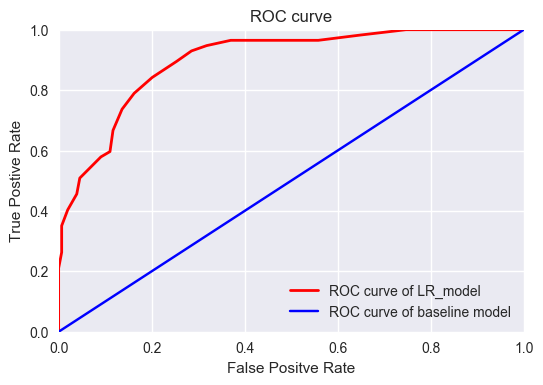

In [15]:
plot_roc(fpr,tpr)

For the baseline model,we randomly pick the probability $P$ of the label of a sample is 1.

Then for the total sample,assume there are $k$ ($k \in [0,1]$) proportion are 1,and record the total number of them as $y_1$,others as $y_0$

So the $TPR =\frac{TP}{TP+FN} = \frac{y_1 \times P}{y_1} = P$ 

$FPR = \frac{FP}{FP+TN} = \frac{y_0\times P}{y_0} = P$

so $TPR==FPR$
then  it's the blue line in the figure. 

And for the ROC curve of Logistic Model,the FPR and TPR vary as the threshold vary